In [8]:
import warnings, torch, shutil
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
pl.seed_everything(123)

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, DeepAR, RecurrentNetwork, GroupNormalizer
from pytorch_forecasting.metrics import MAPE, NormalDistributionLoss, QuantileLoss, SMAPE

from math import floor
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

from AnalyzeTools.models import autoregressive_integrated_moving_average, linear_regression, support_vector_regression, random_forest, gradient_boosting
from AnalyzeTools.prepare import data_split, model_eval, pathForSavingModels, retriveBestModelPath
from AnalyzeTools.preprocess import preprocessData
from AnalyzeTools.superModels import TFT

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

params_path = './Models'

Global seed set to 123


In [9]:
''' Read data '''
raw_file_name = '경략가격집계 - 소,돼지'
product = "pork-hot"
product_attribute = "경락가격"

_output = 'MAX_COST_AMT' # MIN_COST_AMT
default_exclude_cols = ['JUDGE_GUBN', 'JUDGE_BREED', 'JUDGE_SEX', 'SABLE_GUBN', 'ABATT_CODE']

df = pd.read_csv('../Data/beef/경략가격집계 - 소,돼지.csv', encoding = 'euc_kr', engine ='python').query("JUDGE_KIND == 2")

df = df.drop(default_exclude_cols, axis=1)
df = df.groupby(['STD_DATE']).mean().reset_index()
df['STD_DATE'] = df['STD_DATE'].apply(lambda x: "20" + "-".join(x.split("/")))

df, _input = preprocessData(df, 'STD_DATE', _output)


Feature scores:
                 Features        Scores
6  DEFECT_MAX_COST_AMT  6.811574e+10
1         MIN_COST_AMT  1.222592e+04
5  DEFECT_MIN_COST_AMT  1.222443e+04
2         SUM_COST_AMT  4.538033e+02
7  DEFECT_SUM_COST_AMT  4.537454e+02
8    DEFECT_SUM_WEIGHT  2.279391e+01
3           SUM_WEIGHT  2.277102e+01
4           DEFECT_CNT  1.084715e+01
0                  CNT  1.083094e+01

TOP K features:
   ['MIN_COST_AMT', 'SUM_COST_AMT', 'DEFECT_MIN_COST_AMT', 'DEFECT_MAX_COST_AMT']


In [10]:
# prepare dataset for statistics and Macnhine models
ml_split_params = {'Model': 'ML', 'Future': 1}
X_train, X_test, y_train, y_test, input_scaler, output_scaler = data_split(df, input_cols=_input, output=_output, train_size=0.8, scaling=True, **ml_split_params)

''' Input data into models and Evaluate model results '''
ml_searchCV_params = {
    'base_dir': params_path,
    'product': product,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'save': True
}
stdout = True
vis = True

X_train: (2037, 3) y_train: (2037,) X_test: (510, 3) y_test: (510,)


In [58]:
print("\nARIMA")
preds = autoregressive_integrated_moving_average(y_train, y_test[:20], step=1)



ARIMA


MAPE: 0.036008142283185045 R square: 0.2723587862707838


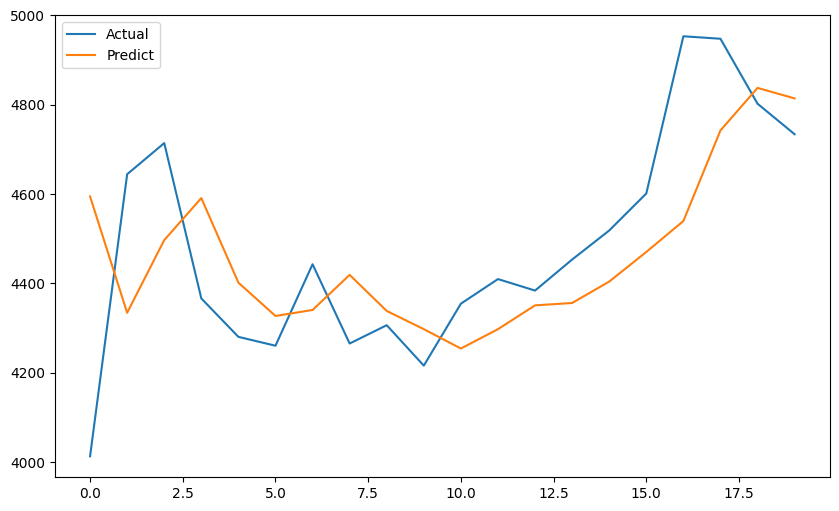

In [59]:
model_eval(y_test[:20], preds, stdout=stdout, vis=vis, **{'scaler': output_scaler})